https://www.kaggle.com/mirichoi0218/insurance#insurance.csv

## Exploratory data analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]

In [5]:
# Getting the Data
raw_df = pd.read_csv("insurance.csv")
raw_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
from data_processing import preprocess_insurance_data
from sklearn.metrics import mean_squared_error, r2_score

df = preprocess_insurance_data(raw_df)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


# Entrenando el modelo

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop("charges", axis=1)
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LinearRegression()
model = reg.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2 score: {r2_score(y_test, y_pred)}')

MSE: 33635210.431178406
R2 score: 0.7833463107364539


# Permutation importance

In [9]:
from eli5 import show_weights
from eli5.sklearn import PermutationImportance

feature_names=X.columns.tolist()

show_weights(PermutationImportance(model).fit(X_test, y_test), feature_names=feature_names)

Weight,Feature
1.1360 ± 0.0765,smoker
0.1655 ± 0.0300,age
0.0501 ± 0.0151,bmi
0.0044 ± 0.0061,children
0.0029 ± 0.0018,region
0.0001 ± 0.0001,sex


# Partial Dependence Plots

## sklearn.inspection

Available features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']


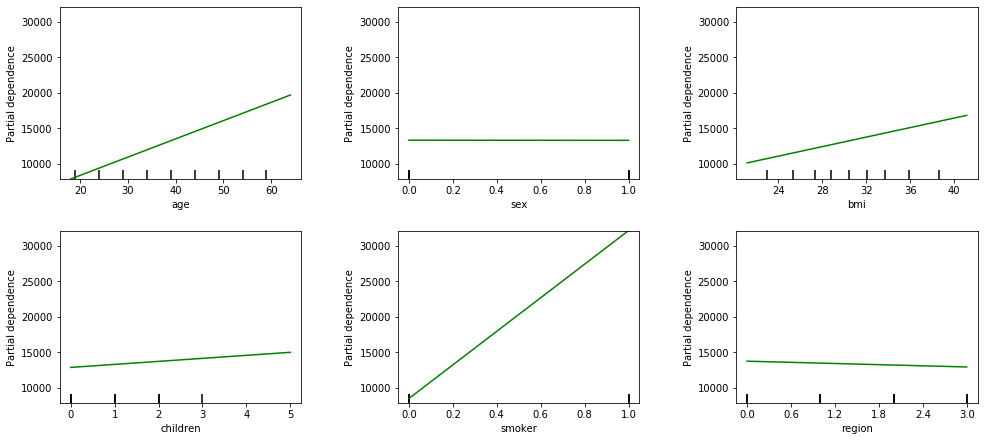

In [11]:
from sklearn.inspection import plot_partial_dependence

print(f'Available features: {df.columns.to_list()}')

plot_partial_dependence(
    model, 
    X=X,  # raw predictors data
    features=[0,1,2,3,4,5],  # column numbers of plots we want to show
    feature_names=feature_names,   # labels on graphs
    n_cols=3,
    grid_resolution=100,
) 

## pdpbox.info_plots

/home/alicia/workspace/ml_bias/venv/lib/python3.7/site-packages/pdpbox/info_plots.py:295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_df['actual_prediction'] = prediction
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


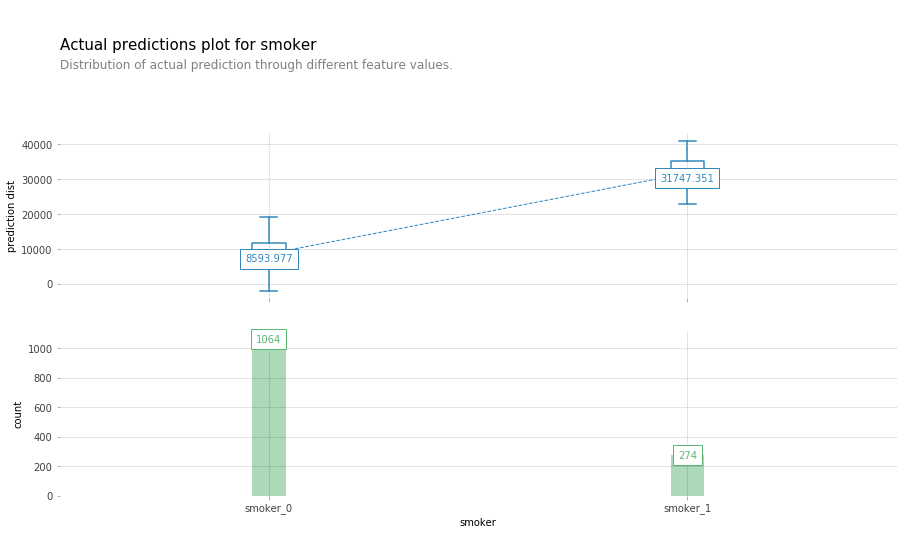

In [12]:
from pdpbox import info_plots

feature_name = 'smoker'

fig, axes, summary_df = info_plots.actual_plot(
    model=model, 
    X=X,
    feature=feature_name, 
    feature_name=feature_name,
    predict_kwds={}
) 

# FairML

In [14]:
from fairml import audit_model

importances, _ = audit_model(model.predict, X)
print(importances)

Feature: age,	 Importance: 625091382.6407907
Feature: sex,	 Importance: -341509525.41341156
Feature: bmi,	 Importance: 637672364.1647611
Feature: children,	 Importance: 308021569.32370245
Feature: smoker,	 Importance: 394875237.29227036
Feature: region,	 Importance: -417273894.5885415


/home/alicia/workspace/ml_bias/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


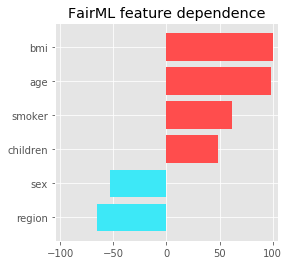

In [15]:
from fairml import plot_dependencies

# generate feature dependence plot
fig = plot_dependencies(
    importances.median(),
    reverse_values=False,
    title="FairML feature dependence"
)
plt.show()